# GoFast

Вы аналитик популярного сервиса аренды самокатов GoFast. Вам передали данные о некоторых пользователях из нескольких городов, а также об их поездках. Проанализируйте данные и проверьте некоторые гипотезы, которые могут помочь бизнесу вырасти.

Чтобы совершать поездки по городу, пользователи сервиса GoFast пользуются мобильным приложением. Сервисом можно пользоваться:

__Без подписки__
* абонентская плата отсутствует;
* стоимость одной минуты поездки — 8 рублей;
* стоимость старта (начала поездки) — 50 рублей;

__С подпиской Ultra__
* абонентская плата — 199 рублей в месяц;
* стоимость одной минуты поездки — 6 рублей;
* стоимость старта — бесплатно.

 __Цель исследования__ - проанализировать развитие сервиса GoFast и помочь бизнесу вырасти. Для этого подсчитаем выручку компании и проверим несколько гипотез:
* Тратят ли пользователи с подпиской больше времени на поездки? 
* Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. 
* Обновление серверов снизит количество обращений в техподдержку.


__Ход исследования__:
1. Загрузка и предобработка данных;
2. Визуализация полученной информации;
3. Подсчет и проверка гипотез. 
    

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from math import ceil
from scipy import stats as st
import numpy as np

## Шаг 1. Загрузка данных

In [2]:
users = pd.read_csv('datasets/users_go.csv')
rides = pd.read_csv('datasets/rides_go.csv')
subscriptions = pd.read_csv('datasets/subscriptions_go.csv')

In [3]:
users.head()

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


В этой таблице находятся основные данные о каждом пользователе - id, имя, возраст и город проживания. Так же указан тип подписки. 

In [4]:
rides.head()

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


Здесь дана информация об активности пользователей (совершеннах поездках):
* distance - расстояние, которое пользователь проехал в текущей сессии;
* duration - продолжительность сессии (в минутах);
* date - дата совершения поездки.

Так же видим, что таблицы users и rides содержат один общий столбец - id пользователя.

In [5]:
subscriptions.head()

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


В таблице subscriptions всего две строки - информация о каждом типе подписки. 

Таким образом, имеем данные о пользователях, их поездках (использовании сервиса) и подписках. 

## Шаг 2. Предобработка данных

Выведем столбец с датами поездок из rides. 

In [6]:
rides['date'].head()

0    2021-01-01
1    2021-01-18
2    2021-04-20
3    2021-08-11
4    2021-08-28
Name: date, dtype: object

Приведем его к типу datetime64:

In [7]:
rides['date'] = pd.to_datetime(rides['date'], format='%Y-%m-%d')

In [8]:
rides['date'].head()

0   2021-01-01
1   2021-01-18
2   2021-04-20
3   2021-08-11
4   2021-08-28
Name: date, dtype: datetime64[ns]

Создадим отдельный столбец с месяцем:

In [9]:
rides['month'] = pd.to_datetime(rides['date']).dt.month

In [10]:
rides.head()

,user_id,distance,duration,date,month
0,1,4409.919140,25.599769,2021-01-01,1
1,1,2617.592153,15.816871,2021-01-18,1
2,1,754.159807,6.232113,2021-04-20,4
3,1,2694.783254,18.511000,2021-08-11,8
4,1,4028.687306,26.265803,2021-08-28,8


Проверим датафреймы users и rides на наличие пропущенных значений и дубликатов:

In [11]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


In [12]:
users.isna().sum()

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64

In [13]:
len(users['user_id'].unique())

1534

Видим, что в столбце user_id 1534 уникальных значения тогда, как в самом столбце их 1565. Так как id пользователя должен быть уникальным значением, удалим строки с дубликатами. Их 31 - следовательно, на общем анализе не отразится.

In [14]:
users.columns = users.columns.str.strip()

In [15]:
users = users.sort_values('user_id')
users = users.drop_duplicates(subset='user_id')

In [16]:
users.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1534 entries, 0 to 1533
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1534 non-null   int64 
 1   name               1534 non-null   object
 2   age                1534 non-null   int64 
 3   city               1534 non-null   object
 4   subscription_type  1534 non-null   object
dtypes: int64(2), object(3)
memory usage: 71.9+ KB


In [17]:
rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
 4   month     18068 non-null  int32         
dtypes: datetime64[ns](1), float64(2), int32(1), int64(1)
memory usage: 635.3 KB


In [18]:
rides.isna().sum()

user_id     0
distance    0
duration    0
date        0
month       0
dtype: int64

Пропусков нет

In [19]:
rides.head()

,user_id,distance,duration,date,month
0,1,4409.919140,25.599769,2021-01-01,1
1,1,2617.592153,15.816871,2021-01-18,1
2,1,754.159807,6.232113,2021-04-20,4
3,1,2694.783254,18.511000,2021-08-11,8
4,1,4028.687306,26.265803,2021-08-28,8


In [20]:
len(rides['user_id'].unique()) 
# здесь user_id могут иметь дубликаты, так как пользователи могут иметь несколько поездок

1534

На данном этапе поменяли тип данных в столбце даты в rides, сделали новый столбец с месяцем, удалили дубликаты в users и проверили датафреймы на наличие пропусков.

## Шаг 3. Исследовательский анализ данных

#### len(users['city'].unique())

In [21]:
city_table = users['city'].value_counts()
city_table

city
Пятигорск         219
Екатеринбург      204
Ростов-на-Дону    198
Краснодар         193
Сочи              189
Омск              183
Тюмень            180
Москва            168
Name: count, dtype: int64

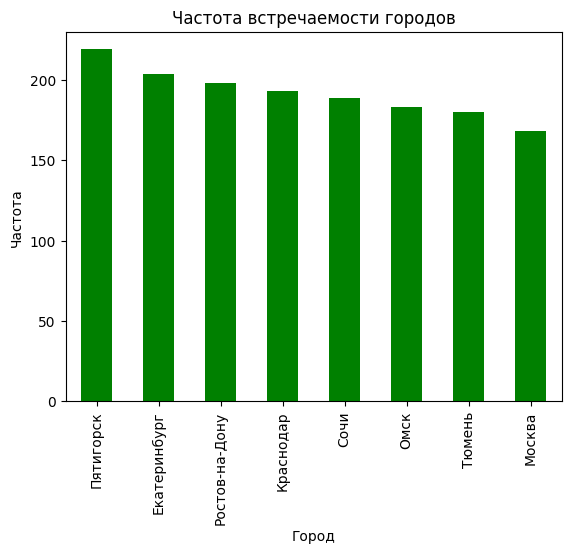

In [22]:
city_table.plot(kind='bar', color='green')
plt.title(label='Частота встречаемости городов')
plt.xlabel('Город')
plt.ylabel('Частота')
plt.show()

Наиболее часто сервис GoFast используется в Пятигорске, Екатеринбурге, Ростове-на-Дону. Реже всего в Москве. 

In [23]:
subscription_type_table = users['subscription_type'].value_counts()
subscription_type_table.index = ['без подписки', 'с подпиской']
subscription_type_table

без подписки    835
с подпиской     699
Name: count, dtype: int64

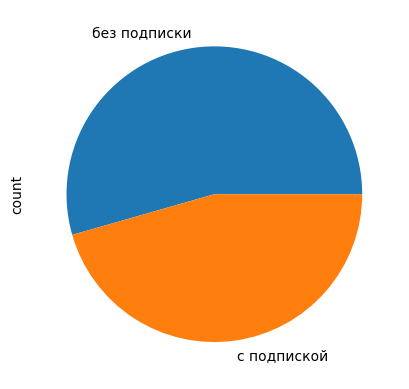

In [24]:
subscription_type_table.plot(kind='pie')
plt.show()

Пользователей без подписки почти на 150 больше. При этом с подпиской тоже достаточно много. 

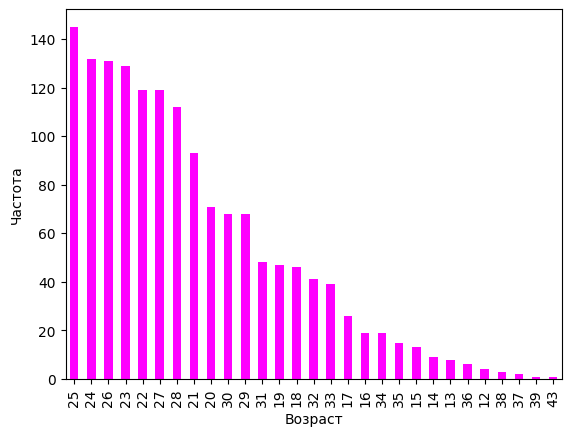

In [25]:
users_table = users['age'].value_counts()
users_table.plot(kind='bar', color='magenta')
plt.xlabel('Возраст')
plt.ylabel('Частота')
plt.show()

Наиболее часто пользуются сервисом люди от 20 до 30 лет, редко - те, кому более 35 лет. 

In [26]:
rides.head()

,user_id,distance,duration,date,month
0,1,4409.919140,25.599769,2021-01-01,1
1,1,2617.592153,15.816871,2021-01-18,1
2,1,754.159807,6.232113,2021-04-20,4
3,1,2694.783254,18.511000,2021-08-11,8
4,1,4028.687306,26.265803,2021-08-28,8


In [27]:
min(rides['distance']), max(rides['distance'])

(0.855682925681208, 7211.007744598519)

<Axes: >

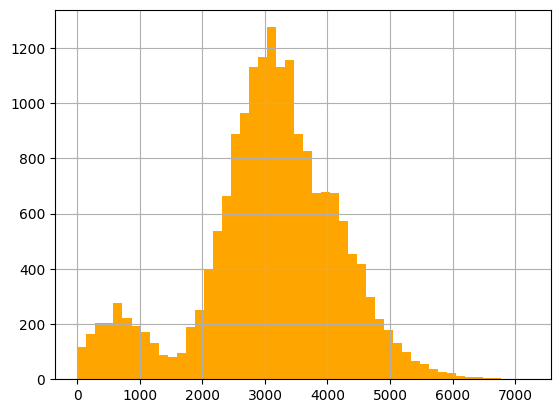

In [28]:
rides['distance'].hist(bins=50, color='orange')

Расстояние поездки как правило попадает в диапазон 2-4 км. 

In [29]:
min(rides['duration']), max(rides['duration'])

(0.5, 40.82396261922424)

<Axes: >

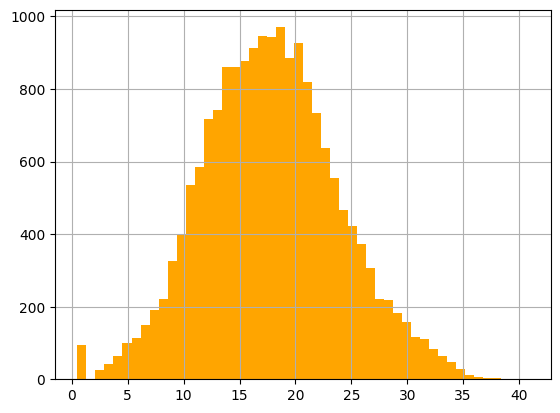

In [30]:
rides['duration'].hist(bins=50, color='orange')

На гистрограмме видим, что есть пик в маленьких значениях, поездки длительностью меньше минуты - это могут быть аномалии или короткие поездки. Так как минимальная дистанция 855 метров, а минимальное время - полминуты, можем сделать вывод, что это аномалии данных, которые стоит удалить. Удалим значения меньше 2-х минут, так как примерно за это время можно проехать 850 метров. 

<Axes: >

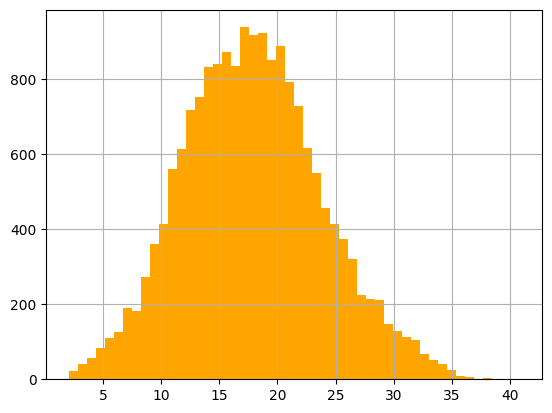

In [31]:
rides = rides[rides['duration'] > 2]
rides['duration'].hist(bins=50, color='orange')

Продолжительность поездок представляет собой нормальное распределение. Наиболее частая продолжительность - от 15 до 20 минут.

## Шаг 4. Объединение данных

Объединим users и rides по общему столбцу 'user_id'. Далее объединим эту таблицу с subscriptions по типу подписки (столбец subscription_type)

users.info()
print()
rides.info()

В таблице rides 17973 записи - поездки, каждая из которых принадлежит одному из пользователей таблицы users. Значит, в итоговой таблице должно оказаться 17973 строк. 

In [32]:
users = users.merge(rides, on='user_id')

In [33]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17973 entries, 0 to 17972
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            17973 non-null  int64         
 1   name               17973 non-null  object        
 2   age                17973 non-null  int64         
 3   city               17973 non-null  object        
 4   subscription_type  17973 non-null  object        
 5   distance           17973 non-null  float64       
 6   duration           17973 non-null  float64       
 7   date               17973 non-null  datetime64[ns]
 8   month              17973 non-null  int32         
dtypes: datetime64[ns](1), float64(2), int32(1), int64(2), object(3)
memory usage: 1.2+ MB


Проверили - все получилось верно. 

In [34]:
subscriptions

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


In [35]:
users = users.merge(subscriptions, on='subscription_type')
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17973 entries, 0 to 17972
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            17973 non-null  int64         
 1   name               17973 non-null  object        
 2   age                17973 non-null  int64         
 3   city               17973 non-null  object        
 4   subscription_type  17973 non-null  object        
 5   distance           17973 non-null  float64       
 6   duration           17973 non-null  float64       
 7   date               17973 non-null  datetime64[ns]
 8   month              17973 non-null  int32         
 9   minute_price       17973 non-null  int64         
 10  start_ride_price   17973 non-null  int64         
 11  subscription_fee   17973 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int32(1), int64(5), object(3)
memory usage: 1.6+ MB


Каждому пользователю соответствует один тип подписки - количество записей осталось прежним. 

Итог:

In [36]:
users.head(10)

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199
5,1,Кира,22,Тюмень,ultra,2770.890808,16.650138,2021-10-09,10,6,0,199
6,1,Кира,22,Тюмень,ultra,3039.020292,14.927879,2021-10-19,10,6,0,199
7,1,Кира,22,Тюмень,ultra,2842.118050,23.117468,2021-11-06,11,6,0,199
8,1,Кира,22,Тюмень,ultra,3412.690668,15.238072,2021-11-14,11,6,0,199
9,1,Кира,22,Тюмень,ultra,748.690645,15.041884,2021-11-22,11,6,0,199


In [37]:
users.isna().sum()

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
distance             0
duration             0
date                 0
month                0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64

Пропуски не возникли, количество записей (размер таблицы) соответствует ожиданию. 

Сделаем отдельную таблицу с данными о пользователях, у которых нет подписки:

In [38]:
users_free = users[users['subscription_type'] == 'free']
users_free.head()

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
6500,700,Айдар,22,Омск,free,2515.690719,14.944286,2021-01-02,1,8,50,0
6501,700,Айдар,22,Омск,free,846.932642,16.234663,2021-02-01,2,8,50,0
6502,700,Айдар,22,Омск,free,4004.434142,20.016628,2021-02-04,2,8,50,0
6503,700,Айдар,22,Омск,free,1205.911290,9.782872,2021-02-10,2,8,50,0
6504,700,Айдар,22,Омск,free,3047.379435,17.427673,2021-02-14,2,8,50,0


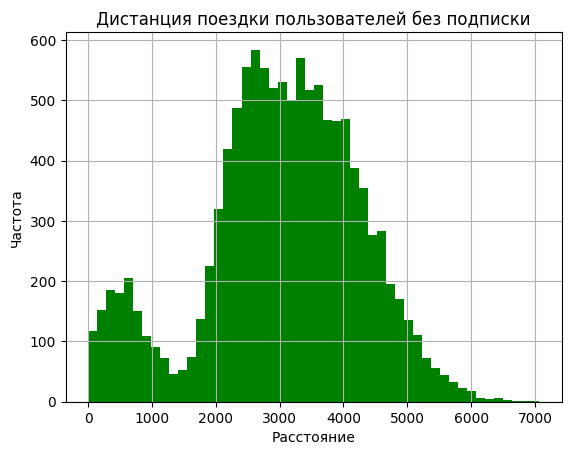

In [39]:
users_free['distance'].hist(bins=50, color='green')
plt.title(label='Дистанция поездки пользователей без подписки')
plt.xlabel('Расстояние')
plt.ylabel('Частота')
plt.show()

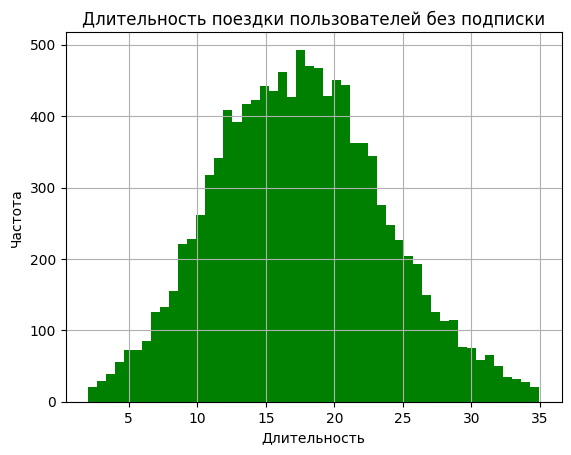

In [40]:
users_free['duration'].hist(bins=50, color='green')
plt.title(label='Длительность поездки пользователей без подписки')
plt.xlabel('Длительность')
plt.ylabel('Частота')
plt.show()

In [41]:
users_free.describe()

,user_id,age,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
count,11473.000000,11473.000000,11473.000000,11473.000000,11473,11473.000000,11473.0,11473.0,11473.0
mean,1120.761701,24.888782,3028.374239,17.530771,2021-07-01 21:50:58.415409920,6.523316,8.0,50.0,0.0
min,700.000000,12.000000,0.855683,2.035632,2021-01-01 00:00:00,1.000000,8.0,50.0,0.0
25%,915.000000,22.000000,2360.878149,13.085688,2021-04-02 00:00:00,4.000000,8.0,50.0,0.0
50%,1123.000000,25.000000,3102.083025,17.383807,2021-07-01 00:00:00,7.000000,8.0,50.0,0.0
75%,1329.000000,28.000000,3883.979311,21.638038,2021-09-30 00:00:00,9.000000,8.0,50.0,0.0
max,1534.000000,43.000000,7066.003772,34.948498,2021-12-30 00:00:00,12.000000,8.0,50.0,0.0
std,241.138659,4.482066,1235.541051,6.162609,NaN,3.447707,0.0,0.0,0.0


В столбце с дистанцией видим два пика - в 2500 м и 3500 м. Средняя дистанция - 3 км. Наиболее частое время поездки - около 17 минут. Большая часть значений лежит примерно в том же диапазоне, что и в общей таблице.

In [42]:
users_ultra = users[users['subscription_type'] == 'ultra']
users_ultra.head()

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199


Text(0, 0.5, 'Частота')

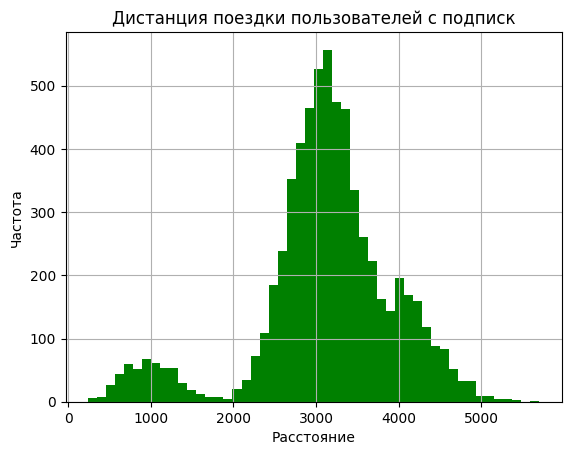

In [43]:
users_ultra['distance'].hist(bins=50, color='green')
plt.title(label='Дистанция поездки пользователей с подписк')
plt.xlabel('Расстояние')
plt.ylabel('Частота')

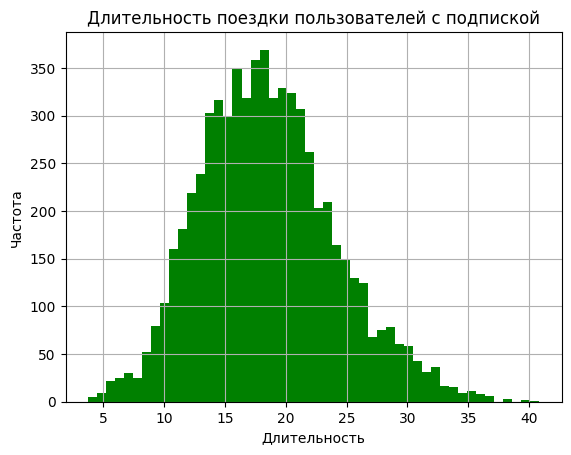

In [44]:
users_ultra['duration'].hist(bins=50, color='green')
plt.title(label='Длительность поездки пользователей с подпиской')
plt.xlabel('Длительность')
plt.ylabel('Частота')
plt.show()

In [45]:
users_ultra.describe()

,user_id,age,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
count,6500.000000,6500.000000,6500.000000,6500.000000,6500,6500.000000,6500.0,6500.0,6500.0
mean,348.725385,24.892615,3115.445388,18.541985,2021-06-28 21:31:34.153846016,6.422308,6.0,0.0,199.0
min,1.000000,12.000000,244.210438,3.760353,2021-01-01 00:00:00,1.000000,6.0,0.0,199.0
25%,175.000000,22.000000,2785.444017,14.524654,2021-04-01 00:00:00,4.000000,6.0,0.0,199.0
50%,351.000000,25.000000,3148.637229,18.178153,2021-06-27 00:00:00,6.000000,6.0,0.0,199.0
75%,525.000000,28.000000,3560.574425,21.884129,2021-09-25 00:00:00,9.000000,6.0,0.0,199.0
max,699.000000,38.000000,5699.769662,40.823963,2021-12-30 00:00:00,12.000000,6.0,0.0,199.0
std,201.099339,4.757208,836.895330,5.572048,NaN,3.414616,0.0,0.0,0.0


В таблице пользователей с подпиской дистанция имеет меньшее стандартное отклонение. Большинство значений лежит в диапазоне 2500 - 3500 м. Значений с дистанцией менее 2 км очень мало. Большинсво значений времени поездки так же находится в диапазоне 10 - 25 мин, как и в общей таблице. Однако гистограмма имеет меньший разброс значений, чем у пользователей без подписки. 

Вывод: статистики поездок пользователей с подпиской и без почти не отличаются. Дистанция пользователей без подписки по всем показателям примерно совпадает с пользователями с подпиской, однако имеет большее стандартное отклонение. Интересно, что максимальная дистанция пользователей без подписки на 1 км больше. Время поездок пользователей с подпиской по показателям обычно на 1-2 мин больше. Максимальное время поездки пользователя с подпиской на 6 мин больше пользователя без нее. Пользователи с подпиской имеют меньшее стандартное отклонение, как и в случае с дистанцией. 

## Шаг 5. Подсчёт выручки

In [46]:
users

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199
...,...,...,...,...,...,...,...,...,...,...,...,...
17968,1534,Альберт,25,Краснодар,free,3781.098080,19.822962,2021-11-04,11,8,50,0
17969,1534,Альберт,25,Краснодар,free,2840.423057,21.409799,2021-11-16,11,8,50,0
17970,1534,Альберт,25,Краснодар,free,3826.185507,18.435051,2021-11-18,11,8,50,0
17971,1534,Альберт,25,Краснодар,free,2902.308661,16.674362,2021-11-27,11,8,50,0


In [47]:
users['duration'] = np.ceil(users['duration']) 
users

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,26.0,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,16.0,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,7.0,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,19.0,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,27.0,2021-08-28,8,6,0,199
...,...,...,...,...,...,...,...,...,...,...,...,...
17968,1534,Альберт,25,Краснодар,free,3781.098080,20.0,2021-11-04,11,8,50,0
17969,1534,Альберт,25,Краснодар,free,2840.423057,22.0,2021-11-16,11,8,50,0
17970,1534,Альберт,25,Краснодар,free,3826.185507,19.0,2021-11-18,11,8,50,0
17971,1534,Альберт,25,Краснодар,free,2902.308661,17.0,2021-11-27,11,8,50,0


Создадим датафрейм с суммарным расстоянием, количеством поездок и суммарным временем для каждого пользователя за каждый месяц:

In [48]:
users_month = users.pivot_table(index=['user_id', 'month'], values=['distance', 'duration'], aggfunc=['sum', 'count'])
users_month.columns = ['total_distance', 'total_duration', 'rides_count', 'rides_count_copy']
users_month = users_month.drop(columns='rides_count_copy') 
users_month = users_month.reset_index()

In [49]:
def subscription_add(row):
    data = users[(users['user_id'] == row['user_id']) & (users['month'] == row['month'])]
    subscription_type = data.iloc[0]['subscription_type']
    return subscription_type

users_month['subscription_type'] = users_month.apply(subscription_add, axis=1)

In [50]:
users_month.head()

,user_id,month,total_distance,total_duration,rides_count,subscription_type
0,1,1,7027.511294,42.0,2,ultra
1,1,4,754.159807,7.0,1,ultra
2,1,8,6723.470560,46.0,2,ultra
3,1,10,5809.911100,32.0,2,ultra
4,1,11,7003.499363,56.0,3,ultra


Рассчитаем выручку от пользователей с подпиской и без и добавим в новый столбец revenue:

In [51]:
users_month['revenue'] = None

In [52]:
def revenue(row):
    if row['subscription_type'] == 'free':
        revenue_from_user = row['total_duration'] * 8 + row['rides_count'] * 50
    else:
        revenue_from_user = row['total_duration'] * 6 + 199
    return revenue_from_user

users_month['revenue'] = users_month.apply(revenue, axis=1)
users_month['revenue'] = users_month['revenue'].astype(int)

In [53]:
users_month.head(20)

,user_id,month,total_distance,total_duration,rides_count,subscription_type,revenue
0,1,1,7027.511294,42.0,2,ultra,451
1,1,4,754.159807,7.0,1,ultra,241
2,1,8,6723.470560,46.0,2,ultra,475
3,1,10,5809.911100,32.0,2,ultra,391
4,1,11,7003.499363,56.0,3,ultra,535
5,1,12,6751.629942,28.0,2,ultra,367
6,2,3,10187.723006,63.0,3,ultra,577
7,2,4,6164.381824,40.0,2,ultra,439
8,2,6,3255.338202,14.0,1,ultra,283
9,2,7,6780.722964,48.0,2,ultra,487


На данном этапе мы рассчитали помесячную выручку, которую принёс каждый пользователь. 

## Шаг 6. Проверка гипотез

__Гипотеза: тратят ли пользователи с подпиской больше времени на поездки?__

In [54]:
len(list(users_free['duration']))

11473

In [55]:
len(list(users_ultra['duration']))

6500

In [56]:
users_free_duration = list(users_free['duration'])
users_ultra_duration  = list(users_ultra['duration'])

alpha = 0.05
results = st.ttest_ind(users_ultra_duration, users_free_duration, alternative='greater')

print('p-значение:', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 4.704468074453899e-28
Отвергаем нулевую гипотезу


Возьмем длительность поездок пользователей с подпиской и без. Уровень статистической значимости принят за 0.05. Гипотеза является односторонней, так как нужно установить больше ли пользователи с подпиской трятят времени на поездки, чем пользователи без подписки. Значение pvalue получилось меньше уровня статистической значимости, следовательно можем отвергуть гипотезу -  пользователи с подпиской не тратят больше времени, чем пользователи без подписки, на поездки.

Нулевая гипотеза: пользователи с подпиской тратят больше времени на поездки

Альтернативная гипотеза: пользователи с подпиской не тратят больше времени на поездки (пользователи с подпиской тратят столько же или меньше времени на поездки)

__Гипотеза: среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров.__

In [57]:
users_ultra.describe()

,user_id,age,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
count,6500.000000,6500.000000,6500.000000,6500.000000,6500,6500.000000,6500.0,6500.0,6500.0
mean,348.725385,24.892615,3115.445388,18.541985,2021-06-28 21:31:34.153846016,6.422308,6.0,0.0,199.0
min,1.000000,12.000000,244.210438,3.760353,2021-01-01 00:00:00,1.000000,6.0,0.0,199.0
25%,175.000000,22.000000,2785.444017,14.524654,2021-04-01 00:00:00,4.000000,6.0,0.0,199.0
50%,351.000000,25.000000,3148.637229,18.178153,2021-06-27 00:00:00,6.000000,6.0,0.0,199.0
75%,525.000000,28.000000,3560.574425,21.884129,2021-09-25 00:00:00,9.000000,6.0,0.0,199.0
max,699.000000,38.000000,5699.769662,40.823963,2021-12-30 00:00:00,12.000000,6.0,0.0,199.0
std,201.099339,4.757208,836.895330,5.572048,NaN,3.414616,0.0,0.0,0.0


In [58]:
dist = list(users_ultra['distance'])
value = 3130

alpha = 0.05

results = st.ttest_1samp(dist, value, alternative='less')

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу') 

p-значение: 0.08046311521502147
Не отвергаем нулевую гипотезу


Возьмем столбец 'distance' из таблицы пользователей с подпиской и уровень статистической значимости 5%. Значение pvalue получилось больше alpha. Значит, среднее расстояние, которое проезжают пользователи с подпиской за одну поездку не превышает 3130 метров - гипотезу опровергнуть не удалось. 

Нулевая гипотеза: среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров
Альтернативная гипотеза: среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, равна или превышает 3130 метров

__Гипотеза: будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки?__

In [59]:
users_month.head()

,user_id,month,total_distance,total_duration,rides_count,subscription_type,revenue
0,1,1,7027.511294,42.0,2,ultra,451
1,1,4,754.159807,7.0,1,ultra,241
2,1,8,6723.470560,46.0,2,ultra,475
3,1,10,5809.911100,32.0,2,ultra,391
4,1,11,7003.499363,56.0,3,ultra,535


Создадим отдельно таблицы с выручкой пользователей с подпиской и без:

In [60]:
revenue_ultra = users_month[users_month['subscription_type'] == 'ultra']
revenue_ultra.head()

,user_id,month,total_distance,total_duration,rides_count,subscription_type,revenue
0,1,1,7027.511294,42.0,2,ultra,451
1,1,4,754.159807,7.0,1,ultra,241
2,1,8,6723.470560,46.0,2,ultra,475
3,1,10,5809.911100,32.0,2,ultra,391
4,1,11,7003.499363,56.0,3,ultra,535


In [61]:
revenue_free = users_month[users_month['subscription_type'] == 'free']
revenue_free.head()

,user_id,month,total_distance,total_duration,rides_count,subscription_type,revenue
4533,700,1,2515.690719,15.0,1,free,170
4534,700,2,13446.659764,89.0,5,free,962
4535,700,3,3798.334905,19.0,1,free,202
4536,700,4,2984.551206,16.0,1,free,178
4537,700,6,5927.650988,29.0,2,free,332


In [62]:
len(revenue_free), len(revenue_ultra)

(6767, 4533)

In [63]:
users_free_revenue = list(revenue_free['revenue'])
users_ultra_revenue  = list(revenue_ultra['revenue'])

alpha = 0.01
results = st.ttest_ind(users_ultra_revenue, users_free_revenue, alternative='greater')

print('p-значение:', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 2.0314113674863288e-30
Отвергаем нулевую гипотезу


Данные - выручки от отдельных пользователей за определенный месяц. Уровень статистической значимости примем за 0.01. Получим pvalue, который меньше 0.01.

Таким образом, отвергли гипотезу о том, что помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.

Нулевая гипотеза: помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки

Альтернативная гипотеза: помесячная выручка от пользователей с подпиской по месяцам не выше, то есть меньше или равна выручке выручке от пользователей без подписки

__Техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест вам понадобился бы для проверки этой гипотезы?__

Нужно сравнить данные о количестве обращений до и после и они являются зависимыми друг от друга выборками. Чтобы проверить гипотезу о равенстве среднего генеральной совокупности для зависимых (парных) выборок в Python, следует использовать метод scipy.stats.ttest_rel().

Нулевая гипотеза: количество обращений в поддержку значительно снизилось из-за обновления серверов. 

Альтернативная гипотеза: количество обращений в поддержку не снизилось значительно из-за обновления серверов. 

## Итоги исследования

В ходе работы проанализировали данные сервиса __GoFast__:
* рассмотрели соотношение пользователей с подпиской и без подписки;
* рассчитали частоту встречаемости городов и возраста пользователей сервиса;
* визуализировали информацию о расстоянии и времени поездок для пользователей обеих категорий;
* сравнили данные пользователей с подпиской и без;
* рассмотрели особенности расстояния и продолжительности поездок;
* подсчитали выручку от пользователей с подпиской и без за каждый месяц.

Проверили гипотезы:
* не удалось отвергнуть гипотезу о том, что пользователи с подпиской тратят больше времени на поездки;
* установили, что что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров;
* отвергли гипотезу о том, что помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.